# Plot Tau performance

Now that we have our simple flat ntuples containg the information about genuine (and fake as well) taus we can start inspecting the performance of CMS Tau reconstruction and ID algorithms.

### Imports and intitialisations

In [2]:
import ROOT # you all know this
import numpy as np # numerical python, backbone of any serious scientific python work

# Enable weighed histograms
ROOT.TH1.SetDefaultSumw2()

# set to True for non graphical mode (useful if the connection is slow
# or you don't want TCanvases popping up all over the place)
ROOT.gROOT.SetBatch(False) 

Welcome to JupyROOT 6.11/02


### Get the DY file

In [3]:
dy_file = ROOT.TFile.Open('dy_tuple.root.backup', 'read')
dy_file.cd()
dy_tree = dy_file.Get('tree')

Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


it contains genunine taus from $DY\rightarrow\tau\tau$, this for sure.

But, are all the taus in this sample genuine hadronically decaying taus?
Let's find out!

In the ntuple, if the had tau is genuine, the matched gen had tau information is saved. Else, it is filled with -99.  
Compare the number of taus for which there a corresponding gen vis tau is found/not found.

In [7]:
print 'all saved reco taus', dy_tree.GetEntries()
print '\tof which, ', dy_tree.GetEntries('tau_gen_pt>=0'), 'are genuine'
print '\tand', dy_tree.GetEntries('tau_gen_pt<0'), 'are not!'

all saved reco taus 509870
	of which,  67075 are genuine
	and 442795 are not!


### Inspect these fakes
The $p_{T}$ spectrum, before any selection, looks funny

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


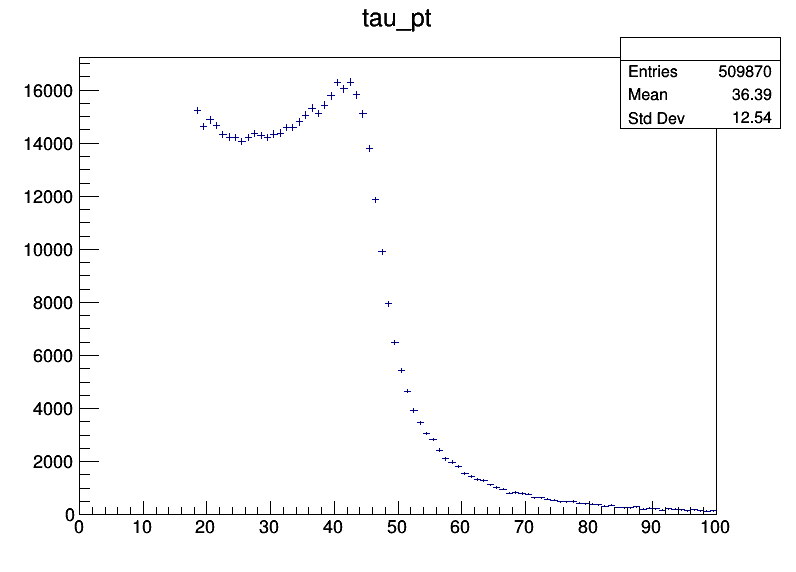

In [11]:
c1 = ROOT.TCanvas("c1","The Canvas Title",800,600) # you need to draw a TCanvas first, in order to display plots inline in upyter
c1.Draw()
dy_tree.Draw('tau_pt>>(100, 0, 100)') # Draw

these are prompt $\mu$ and e from $DY\rightarrow\ell\ell$ and leptonic $\tau$ decays.  
There are dedicated discriminators to suppress them, the so called anti-muon and anti-electron discriminator.  

Let's select taus that pass the Tight WP and see how fakes get reduced

In [12]:
print 'all saved reco taus', dy_tree.GetEntries('tau_idAntiEle>=31 & tau_idAntiMu>=3') # how do I know which cut to apply?
print '\tof which, ', dy_tree.GetEntries('tau_gen_pt>=0 & tau_idAntiEle>=31 & tau_idAntiMu>=3'), 'are genuine'
print '\tand', dy_tree.GetEntries('tau_gen_pt<0 & tau_idAntiEle>=31 & tau_idAntiMu>=3'), 'are not!'

all saved reco taus 67847
	of which,  47957 are genuine
	and 19890 are not!


much better, what about the $p_{T}$ distribution?

67847L

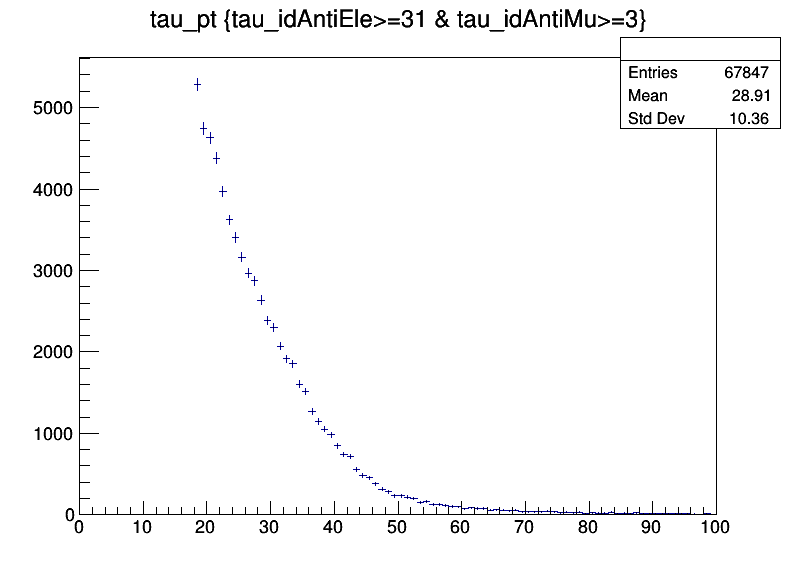

In [14]:
c1.Draw()
dy_tree.Draw('tau_pt>>(100, 0, 100)', 'tau_idAntiEle>=31 & tau_idAntiMu>=3') # Draw

This looks sane enough.  
For the rest of the exercise let's get rid of $\ell\rightarrow\tau$ and always apply the two discriminants above.

### Remarks on gen information

There is a shortcut to know immediately which gen particle gave rise to a given reco tau, and it is saven in the ntuples, `tau_genPartFlav`, see the documentation at [https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc102X_doc.html#Tau](https://cms-nanoaod-integration.web.cern.ch/integration/master-102X/mc102X_doc.html#Tau):  

`Flavour of genParticle for MC matching to status==2 taus: 1 = prompt electron, 2 = prompt muon, 3 = tau->e decay, 4 = tau->mu decay, 5 = hadronic tau decay, 0 = unknown or unmatchedFlavour of genParticle for MC matching to status==2 taus: 1 = prompt electron, 2 = prompt muon, 3 = tau->e decay, 4 = tau->mu decay, 5 = hadronic tau decay, 0 = unknown or unmatched`  

Jets faking taus also fall into `tau_genPartFlav=0`

509870L

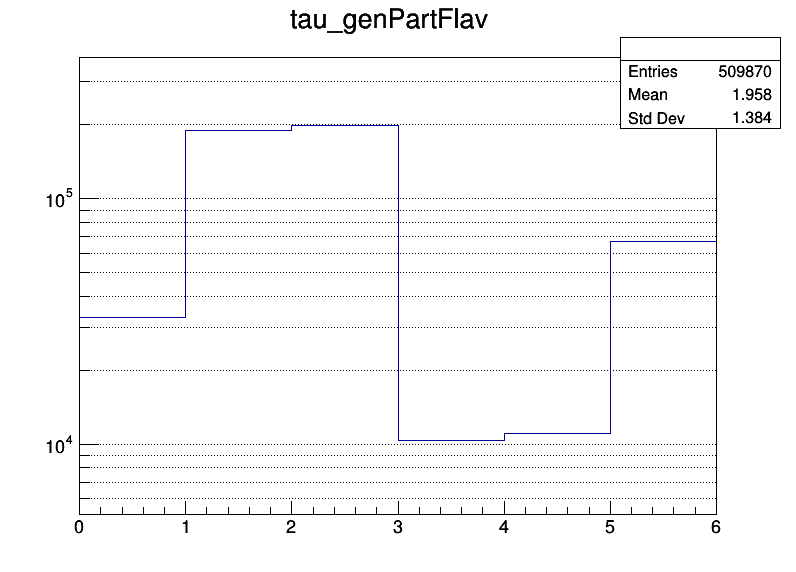

In [19]:
c1.Draw()
c1.SetLogy()
c1.SetGridy()
dy_tree.Draw('tau_genPartFlav >> (6, 0, 6)', '', 'hist')

# TauID efficiency for genuine $\tau$'s
As you've seen during the presentation, the major source of fake taus, even more relevant than leptons (can you tell why this?), comes from miss-reconstructed jets.  
Therefore, it is very important to estimate the performance tau isolation, in terms of both efficiency and fake rejection.  

For this part of the exercise let's use the MVA based Tau ID (we call this ID because there is more than just isolation, in fact it combines the isolation with other observables that can clearly indicate a tau signature, such as decay length, 3-prong vertex etc...) in its most recent incarnation 2017v2.

### Reconstruct the WP <--> value in the branch correspondance
may look strange, but this is an effect of bitmasking (info is compressed in nanoAODs)  
```
idMVAnewDM2017v2 WPs
0    not passed
1    VVLoose 
3    VLoose 
7    Loose  
15   Medium  
31   Tight   
63   VTight  
127  VVTight 
```
can be remapped to 0 - 6 through `np.log2((tau_idMVAnewDM2017v2 + 1)>>1)`  

For now, let's just use the values stored in the ntuples

Warning in <TFile::Append>: Replacing existing TH1: iso_pt_den (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iso_pt_num (Potential memory leak).


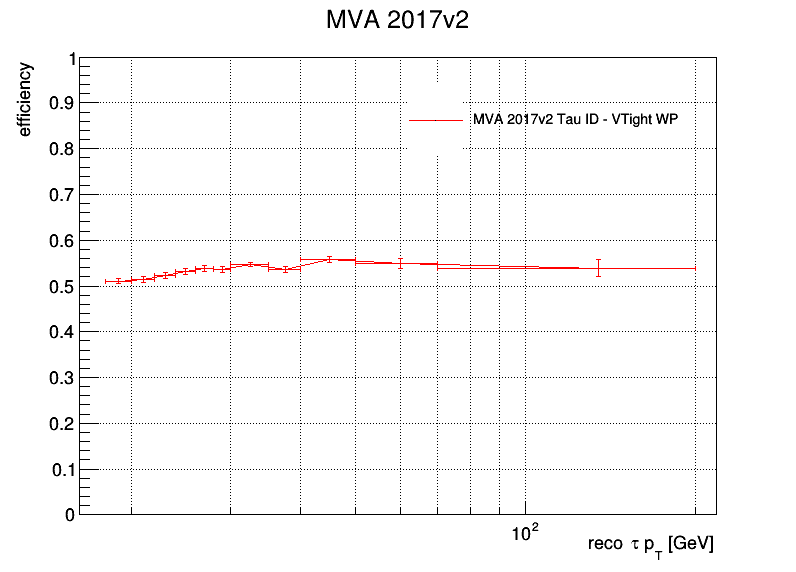

In [22]:
# choose a variable binning for the pt distribution
# Q: why variable?
pt_binning = np.array([0., 18., 20., 22., 24., 26., 28., 30., 35., 40., 50., 70., 200.])

# Select genuine taus, based on gen level information, 
# that is, if a gen visible tau is matched to the reco tau
true_tau_selection = 'tau_gen_pt>=0' # unmatched taus are set to default -99.

# Define the denominator and numerator selections
# Consider only taus with pt>18 GeV. 
# This is the minimum recommended pt for which the HPS algorithm is guaranteed to work 
# Add some very minimal isolation requirement
den_selection = '&'.join(['tau_pt>18', 'abs(tau_eta)<2.3', 'tau_idMVAnewDM2017v2>=1', true_tau_selection])
# at the numerator, count taus that pass your preferred isolation WP
num_selection = '&'.join([den_selection, 'tau_idMVAnewDM2017v2 >= 63'])

# Define numerator and denominator histograms.
# Nota Bene: they must have the same binning 
histo_iso_pt_den = ROOT.TH1F('iso_pt_den', '', len(pt_binning)-1, pt_binning)
histo_iso_pt_num = ROOT.TH1F('iso_pt_num', '', len(pt_binning)-1, pt_binning)

# Select the events from the tree and draw the histograms
# This method is typically much faster than looping 
dy_tree.Draw('tau_pt >> iso_pt_den', den_selection)
dy_tree.Draw('tau_pt >> iso_pt_num', num_selection)

# Divide num / den
# Prefer using ROOT's TEfficiency
# https://root.cern.ch/doc/master/classTEfficiency.html
iso_efficiency = ROOT.TEfficiency(histo_iso_pt_num, histo_iso_pt_den) # Q: can different constructors be used? Check with ipython: ROOT.TEfficiency?
iso_efficiency.SetLineColor(ROOT.kRed)
iso_efficiency.SetFillColor(0)
c1.Draw()
c1.SetGridx(True)
iso_efficiency.Draw('apl')
ROOT.gPad.SetLogx(True)
ROOT.gPad.SetLogy(False)
ROOT.gPad.Update()
iso_efficiency.SetTitle('MVA 2017v2; reco #tau p_{T} [GeV]; efficiency') 
iso_efficiency.GetPaintedGraph().GetYaxis().SetRangeUser(0, 1.)
ROOT.gPad.Update()

# be a better person, always add a legend
leg = ROOT.TLegend(.5,.7,.88,.88)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.AddEntry(iso_efficiency, 'MVA 2017v2 Tau ID - VTight WP')
leg.Draw('same')

### À vous de jouer: plot the TauID efficiency as a funtion of the number of primary vertices

Warning in <TFile::Append>: Replacing existing TH1: iso_pu_den (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: iso_pu_num (Potential memory leak).


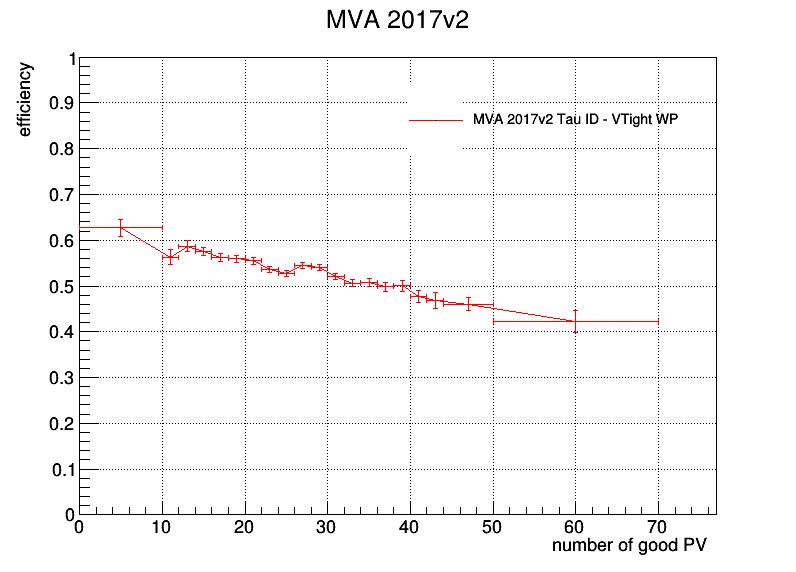

In [24]:
##########################################################################################
# Now, let's check the PU dependency
##########################################################################################

pu_binning = np.array([0., 10.] + range(12, 46, 2) + [50., 70.])

# Select genuine taus, based on gen level information, 
# that is, if a gen visible tau is matched to the reco tau
true_tau_selection = 'tau_gen_pt>=0' # unmatched taus are set to default -99.

# Define the denominator and numerator selections
# Consider only taus with pt>18 GeV. 
# This is the minimum recommended pt for which the HPS algorithm is guaranteed to work 
# Add someminimal isolation requirement
den_selection = '&'.join(['tau_pt>18', 'abs(tau_eta)<2.3', 'tau_idMVAnewDM2017v2>=1', true_tau_selection])
# at the numerator, count taus that pass your preferred isolation WP
num_selection = '&'.join([den_selection, 'tau_idMVAnewDM2017v2 >= 63'])

# Define numerator and denominator histograms.
# Nota Bene: they must have the same binning 
histo_iso_pu_den = ROOT.TH1F('iso_pu_den', '', len(pu_binning)-1, pu_binning)
histo_iso_pu_num = ROOT.TH1F('iso_pu_num', '', len(pu_binning)-1, pu_binning)

# Notice that now we plot the number of good vertices!
dy_tree.Draw('ngvtx >> iso_pu_den', den_selection)
dy_tree.Draw('ngvtx >> iso_pu_num', num_selection)

# Divide num / den
# Prefer using ROOT's TEfficiency
# https://root.cern.ch/doc/master/classTEfficiency.html
iso_efficiency = ROOT.TEfficiency(histo_iso_pu_num, histo_iso_pu_den) # Q: can different constructors be used? Check with ipython: ROOT.TEfficiency?
iso_efficiency.SetLineColor(ROOT.kRed)
c1.Draw()
iso_efficiency.Draw('apl')
iso_efficiency.SetFillColor(0)
ROOT.gPad.SetLogx(False)
ROOT.gPad.Update()
iso_efficiency.SetTitle('MVA 2017v2; number of good PV; efficiency') 
iso_efficiency.GetPaintedGraph().GetYaxis().SetRangeUser(0, 1.)
ROOT.gPad.Update()

# be a better person, always add a legend
leg = ROOT.TLegend(.5,.7,.88,.88)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.AddEntry(iso_efficiency, 'MVA 2017v2 Tau ID - VTight WP')
leg.Draw('same')


### Question: why it is important that the efficiency as a funciton of PU be as flat as possible?

### À vous de jouer: reproduce the same plots for different TauID WPs and compare

# TauID efficiency for jets faking $\tau$'s
Efficiency is not enough, performance are not complete without knowing the fake rate, a.k.a. $j\rightarrow\tau_h$ probability, aka FR.   

For this, since we're dealing with actual jet, it is more appropriate to parametrise the FR as a function of the seeding jet kinematics, rather than $\tau$'s.  
Remember what we discussed in the presentation, seeding jet $p^j_{T} \neq p^{\tau}_{T}$: plot the difference $p^j_{T} - p^{\tau}_{T}$ and observe prove this.

506988L

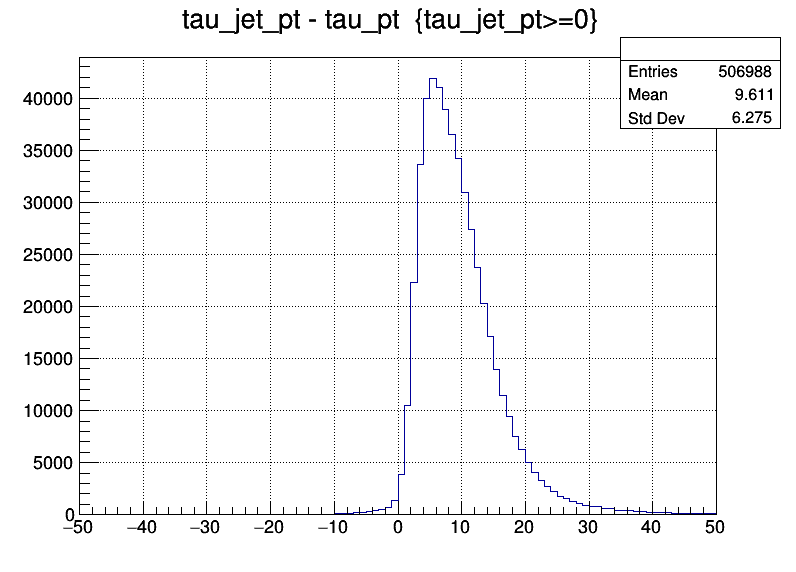

In [29]:
c1.Draw()
# let's use dy_tree.root one more time, before moving to qcd_tree.root 
dy_tree.Draw('tau_jet_pt - tau_pt >> (100, -50, 50)', 'tau_jet_pt>=0', 'hist')

### Question: what's the reason for the small tail below 0?

## TauID fake rate vs. jet $p_{T}$

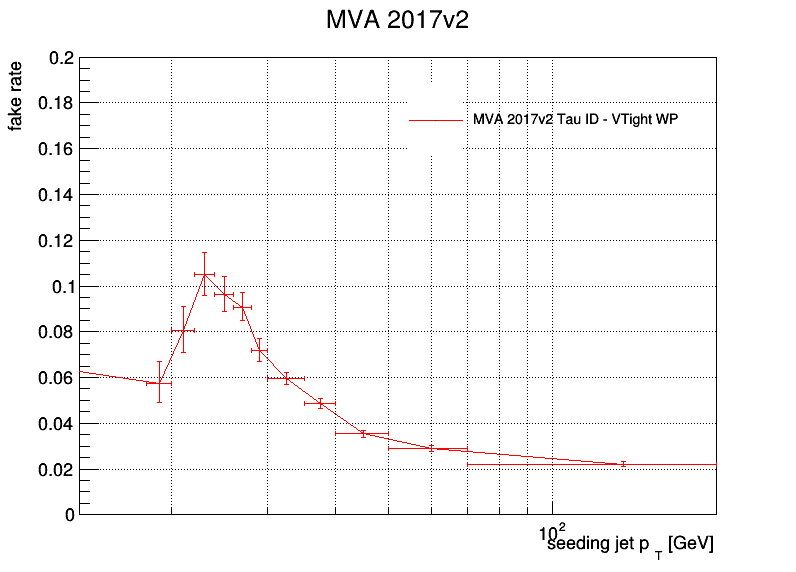

In [34]:
# let's open the qcd file, enriched in jets --> taus
qcd_file = ROOT.TFile.Open('qcd_tuple.root.backup', 'read')
qcd_file.cd()
qcd_tree = qcd_file.Get('tree')

# Select fake taus, based on gen level information, 
fake_tau_selection = 'tau_gen_pt<=0 & tau_genPartFlav==0' # unmatched taus are set to default -99.

# Define denominator and numerator selection as before *except* we focus on fake taus now
den_selection = '&'.join(['tau_pt>18', 'abs(tau_eta)<2.3', 'tau_idMVAnewDM2017v2>=1', fake_tau_selection])
num_selection = '&'.join([den_selection, 'tau_idMVAnewDM2017v2 >= 63'])

# Define numerator and denominator histograms.
# Nota Bene: they must have the same binning 
histo_iso_pt_den = ROOT.TH1F('iso_pt_den', '', len(pt_binning)-1, pt_binning)
histo_iso_pt_num = ROOT.TH1F('iso_pt_num', '', len(pt_binning)-1, pt_binning)

# Select the events from the tree and draw the histograms
# notice that now we plot as a function of the seeding jet pt!!
qcd_tree.Draw('tau_jet_pt >> iso_pt_den', den_selection)
qcd_tree.Draw('tau_jet_pt >> iso_pt_num', num_selection)

# Divide num / den
iso_efficiency = ROOT.TEfficiency(histo_iso_pt_num, histo_iso_pt_den) # Q: can different constructors be used? Check with ipython: ROOT.TEfficiency?
iso_efficiency.SetLineColor(ROOT.kRed)
iso_efficiency.SetFillColor(0)
c1.Draw()
iso_efficiency.Draw('apl')
ROOT.gPad.SetLogx(True)
ROOT.gPad.Update()
iso_efficiency.SetTitle('MVA 2017v2; seeding jet p_{T} [GeV]; fake rate') 
iso_efficiency.GetPaintedGraph().GetYaxis().SetRangeUser(0, 0.2)
iso_efficiency.GetPaintedGraph().GetXaxis().SetRangeUser(15, 200)
ROOT.gPad.Update()

# be a better person, always add a legend
leg = ROOT.TLegend(.5,.7,.88,.88)
leg.SetBorderSize(0)
leg.SetFillColor(0)
leg.SetFillStyle(0)
leg.AddEntry(iso_efficiency, 'MVA 2017v2 Tau ID - VTight WP')
leg.Draw('same')


### Questions: 
* why the fake rate seems so large, ~10%?
* notice the _up-then-down_ trend? Convince yourselves it is an effect due to $p^j_{T} \neq p^{\tau}_{T}$.  
If you're still not convinced, just reproduce the same plot a function of $p^{\tau}_{T}$

# TauID [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
It if often useful to compare the performance of different discriminator in a general way and not for a fixed working point.  
Here is where ROC curves can help, as they can illustrate the ability of a binary classifier (e.g. TauID discriminator: is genuine $\tau$ / is fake) system as its discrimination threshold is varied.